# Prediction of the KS system: a model using Convolutional Neural Network

In this notebook, I will use the CNN to predict many step of the KS system

In [0]:
import numpy as np
import torch as th
import time
from scipy import stats
#from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [0]:
#Set a javascript interval to click on the connect button every 60 seconds. 
#Open developer-settings (in your web-browser) with Ctrl+Shift+i then click 
#on console tab and type this on the console prompt.
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

In [0]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf(t_axis[startT:endT], x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Time evolution')
    plt.ylabel('Position X')
    plt.title('Spatiotemporal solution of KS equation')
    plt.show()

In [0]:
def plothist(state_history,bins=30):
    """
    plot the histogram of KS system data with the correct label
    
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(state_history,bins=30)
    plt.xlabel('Values of velocity')
    plt.ylabel('Frequency')
    plt.title('Histogram of state_history')
    plt.grid(True, color="#93a1a1", alpha=0.3)

In [0]:
def statvalues(state_history):
    """
    print some statistics values of the KS data
    
    """
    print('Mean:', np.mean(state_history))
    print('Median:', np.median(state_history))
    print('Max:', np.max(state_history))
    print('Min:', np.min(state_history))
    print('Mode:', stats.mode(state_history))
    print('Variance:', np.var(state_history))


In [0]:
def evolutionstat(state_history):
  """
  plot the temporal evolution of some statistics values
  
  """  
  plt.subplots(figsize=(15, 7))
  plt.subplot(2,3,1)
  plt.plot(np.mean(state_history,axis=1))
  plt.title('Mean')
  plt.ylabel('Mean value')
  plt.subplot(2,3,2)
  plt.plot(np.median(state_history,axis=1))
  plt.title('Median')
  plt.ylabel('Median value')
  plt.subplot(2,3,3)
  plt.plot(np.max(state_history,axis=1))
  plt.title('Max')
  plt.ylabel('Max value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,4)
  plt.plot(np.min(state_history,axis=1))
  plt.title('Min')
  plt.ylabel('Min value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,5)
  plt.plot(np.var(state_history,axis=1))
  plt.title('Variance')
  plt.ylabel('Variance value')
  plt.xlabel('Time evolution')

In [0]:
def prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """

    y_true=state_history_norm_th[start_position:start_position+(N_step_simu*steps_to_predict),:].squeeze()
    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, sample_points, size_conv_time))
    current_state[0,:,:] = state_history_norm_th[start_position-(size_conv_time):start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((N_step_simu, steps_to_predict,sample_points))

    for i in range(N_step_simu):
        y=model(current_state)
        yy=y[0].reshape(sample_points,steps_to_predict)
        yy=yy.T
        prediction_model[i,:,:]=yy
        y=y.reshape(1,sample_points,steps_to_predict)
        past=current_state[:,:,steps_to_predict:size_conv_time]
        current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
        current_state[:,:,0:(size_conv_time-steps_to_predict)]=past
        current_state[:,:,(size_conv_time-steps_to_predict):]=y


    prediction_model_np = prediction_model.detach().numpy()
    prediction_model_np= prediction_model_np.reshape(N_step_simu*steps_to_predict,sample_points)
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    print('The true solution:')
    drawKS(y_true_np, position_x, time_counter[start_position:start_position+N_step_simu*steps_to_predict] ,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4) 
    print('The model solution:')
    drawKS(prediction_model_np, position_x,time_counter[start_position:start_position+N_step_simu*steps_to_predict] ,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4)

    plt.plot(np.absolute(dif))
    plt.title('Difference between prediction and true value')
    plt.ylabel('Delta')
    plt.xlabel('Time step')
    
    return prediction_model_np,y_true_np

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [0]:
final_time = 10000 # the total time of the simulation
dt = 0.05 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system
#state_initial = np.loadtxt('u1.dat') #the observed initial state of the system

In [0]:
cd ..

/kaggle


In [0]:
cd ../kaggle/input/data-of-the-simulation-u3/

[Errno 2] No such file or directory: '../kaggle/input/data-of-the-simulation-u3/'
/kaggle/input/data-of-the-simulation-u3


In [9]:
#to load data

from numpy import load
# load numpy array
state_history = np.loadtxt('state_history_u3.dat')
time_counter = np.loadtxt('time_counter_u3.dat')
position_x = np.loadtxt('position_u3.dat')

print('The state_history shape is:', state_history.shape)
print('The final time:', time_counter[-1])
print('Total length', position_x[1]+position_x[-1])

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0


Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

Mean: 0.0037720958739586776
Median: 0.02334210639889245
Max: 0.4565350850600155
Min: -0.4433889069435318
Mode: ModeResult(mode=array([-0.44338891]), count=array([1]))
Variance: 0.05437736519905126


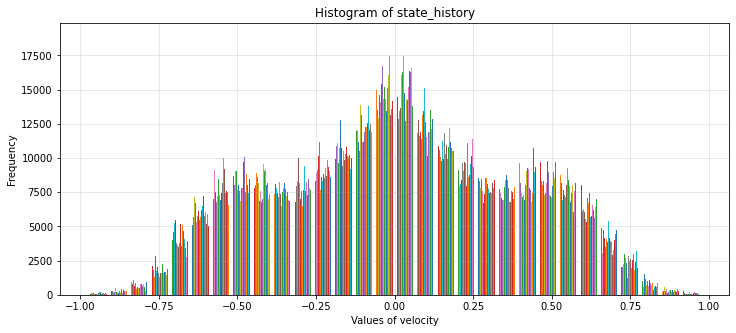

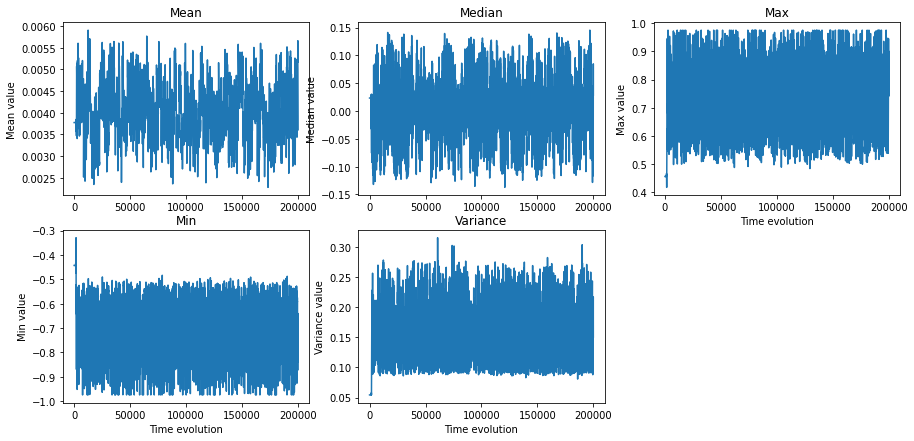

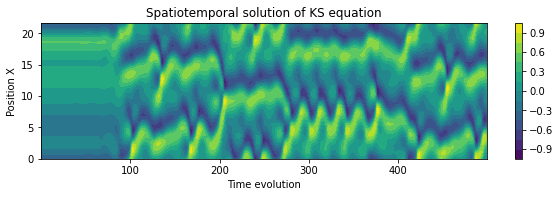

In [10]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

#histogram
plothist(state_history_norm,bins=30)

#statistic values
statvalues(state_history_norm[0,:])

#evolution of statistic values
evolutionstat(state_history_norm)

#KSflow
drawKS(state_history_norm, position_x, time_counter ,startT=1,endT=int(time_counter[-1]), width = 10, divwidth = 4)

## Separating the data into training and test sets

In [11]:
state_history_norm=state_history_norm[:80000,:]
#até 100.000 vai, com 200.000 o colabs nao aguenta
state_history_norm.shape

(80000, 64)

In [0]:
size_conv_time=150
steps_to_predict=50

X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

NN = state_history_norm.shape[0]-2*size_conv_time
Nt = int(NN*0.9) # number of train
Nv = int(NN*0.1) # number of validation


np.random.seed(0)
indices=np.arange(NN)
np.random.shuffle(indices)
train_ind=indices[0:Nt]
valid_ind=indices[-Nv:]


X_train = np.zeros((Nt, sample_points, size_conv_time))
aux=0
for ind in train_ind:
    X_train[aux,:,:]=X[ind:ind+size_conv_time].T
    aux=aux+1

Y_train = np.zeros((Nt, sample_points, steps_to_predict))
aux=0
for ind in train_ind:
    Y_train[aux,:,:]=Y[ind:ind+steps_to_predict].T
    aux=aux+1

Y_train = Y_train.reshape(Nt,sample_points*steps_to_predict)

X_valid = np.zeros((Nv, sample_points, size_conv_time))
aux=0
for ind in valid_ind:
    X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
    aux=aux+1

Y_valid = np.zeros((Nv, sample_points, steps_to_predict))
aux=0
for ind in valid_ind:
    Y_valid[aux,:,:]=Y[ind:ind+steps_to_predict].T
    aux=aux+1

Y_valid = Y_valid.reshape(Nv,sample_points*steps_to_predict)

#converting to tensor
X_train_th = th.from_numpy(X_train).cuda()
#Y_train_th = th.from_numpy(Y_train).cuda()
X_valid_th = th.from_numpy(X_valid).cuda()
#Y_valid_th = th.from_numpy(Y_valid).cuda()

In [0]:
print(X_train_th.shape)
print(Y_train_th.shape)

## Training

In [0]:
def train(model,X_train,X_valid,Y_train,Y_valid,epochs=1000,batch_size=64):
    Nt=len(X_train)
    Nv=len(X_valid)
    ### Mini-batching and shuffle
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss\tValid Loss")
    
    #Just to see the prediction of our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        ttf_calc=model(X_valid).squeeze()
        ttf = Y_valid
        loss=loss_fn(ttf_calc,ttf)
        running_loss+=loss.item()
        valid_losses.append(running_loss)
        #it will print the result in epoch=0 during the training
    
    #starting the training here:
    for e in range(epochs):
        model.train()
        #print("{}\t".format(e),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            
        # training is over for one epoch
        #now evaluate the model with the valid set:
        model.eval()
        accuracy=0
        train_losses.append(running_loss/nbatch)
        running_loss=0
        with th.no_grad():
            x = X_valid
            ttf_calc=model(x).squeeze()
            ttf = Y_valid
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
            valid_losses.append(running_loss)
    #print("{}\t".format(e+1),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))     
    #print("---------- Best : {:.3f}".format(min(valid_losses)), " at epoch " 
    #      , np.fromiter(valid_losses, dtype=np.float).argmin(), " / ",epochs )
    #print('Execution time={:.2f}s'.format(time.time()-start_time))
    #plot some graphs
    #plt.figure(figsize = (9, 1.5))
    #ax= plt.subplot(1, 2, 1)
    #plt.plot(train_losses)
    #ax.set_ylim(bottom=0)
    #ax= plt.subplot(1, 2, 2)
    #plt.plot(valid_losses)
    #ax.set_ylim(bottom=0)
    return train_losses, valid_losses

## Model 1

In [0]:
Lin = size_conv_time
in_ch_conv_1 = sample_points
out_ch_conv_1 = 128
k_conv_1 = 10
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 12
st_pool_2= 1
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = sample_points
hidden_1 = sample_points*5
out_lin = sample_points*steps_to_predict


model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_1,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [0]:
epochs_counter=100
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [0]:
model

In [0]:
cd ..

In [0]:
cd ../kaggle/working

In [0]:
#TO SAVE THE MODEL

# Here we create a dictionnary to store what we need: 
# 1/ the epoch number
# 2/ the batch size
# 2/ the paramters of the model
# 3/ the paramters of the optimizer
# 4/ the loss function we used
tosave_data = {'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv3_model2_u3")

In [0]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=200
N_step_simu=4
print('Start_position=', start_position)
pp,yy = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)


## Model 2

In [0]:
Lin = size_conv_time
in_ch_conv_1 = 64
out_ch_conv_1 = 128
k_conv_1 = 4
st_conv_1 = 2
pad_conv_1 = 4
L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

k_pool_1= 2
st_pool_1= 2
L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

in_ch_conv_2 = 128
out_ch_conv_2 = 64
k_conv_2 = 5
st_conv_2 = 2
pad_conv_2 = 1
L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

k_pool_2= 5
st_pool_2= 2
L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

in_lin = int(sample_points*L_5)
hidden_1 = sample_points*25
out_lin = sample_points*steps_to_predict

model = th.nn.Sequential(
    th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_1,st_pool_1),
    th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
    th.nn.LeakyReLU(),
    th.nn.MaxPool1d(k_pool_2,st_pool_2),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_1,out_lin),
    th.nn.Tanh(),
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [0]:
cd ../kaggle/working/

/kaggle/working


In [0]:
#training with different epochs

for i in range(50):
    epochs_counter=5
    batch_size=64
    train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)
    tosave_data = {'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
    th.save(tosave_data, str(i))
    

In [0]:
model

In [0]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=200
N_step_simu=100
print('Start_position=', start_position)
pp,yy = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)

In [0]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=3000
N_step_simu=30
print('Start_position=', start_position)
pp,yy = prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)

In [1]:
#training with different steps_to_predict


for i in range(12):
    
    size_conv_time=150
    steps_to_predict = (i+1)*5

    Y_train = np.zeros((Nt, sample_points, steps_to_predict))
    aux=0
    for ind in train_ind:
        Y_train[aux,:,:]=Y[ind:ind+steps_to_predict].T
        aux=aux+1

    Y_train = Y_train.reshape(Nt,sample_points*steps_to_predict)


    Y_valid = np.zeros((Nv, sample_points, steps_to_predict))
    aux=0
    for ind in valid_ind:
        Y_valid[aux,:,:]=Y[ind:ind+steps_to_predict].T
        aux=aux+1

    Y_valid = Y_valid.reshape(Nv,sample_points*steps_to_predict)

    #converting to tensor
    Y_train_th = th.from_numpy(Y_train).cuda()
    Y_valid_th = th.from_numpy(Y_valid).cuda()
    
    Lin = size_conv_time
    in_ch_conv_1 = 64
    out_ch_conv_1 = 128
    k_conv_1 = 4
    st_conv_1 = 2
    pad_conv_1 = 4
    L_2 = (Lin+2*pad_conv_1-(k_conv_1-1)-1)/st_conv_1+1

    k_pool_1= 2
    st_pool_1= 2
    L_3 = (L_2 - k_pool_1)/st_pool_1 + 1

    in_ch_conv_2 = 128
    out_ch_conv_2 = 64
    k_conv_2 = 5
    st_conv_2 = 2
    pad_conv_2 = 1
    L_4 = (L_3+2*pad_conv_2-(k_conv_2-1)-1)/st_conv_2+1

    k_pool_2= 5
    st_pool_2= 2
    L_5 = (L_4 - k_pool_2)/st_pool_2 + 1

    in_lin = int(sample_points*L_5)
    hidden_1 = sample_points*25
    out_lin = int(sample_points*steps_to_predict)

    model = th.nn.Sequential(
        th.nn.Conv1d(in_ch_conv_1,out_ch_conv_1,k_conv_1,st_conv_1,pad_conv_1),
        th.nn.LeakyReLU(),
        th.nn.MaxPool1d(k_pool_1,st_pool_1),
        th.nn.Conv1d(in_ch_conv_2,out_ch_conv_2,k_conv_2,st_conv_2,pad_conv_2),
        th.nn.LeakyReLU(),
        th.nn.MaxPool1d(k_pool_2,st_pool_2),
        th.nn.Flatten(),
        th.nn.Linear(in_lin,hidden_1),
        th.nn.LeakyReLU(),
        th.nn.Linear(hidden_1,out_lin),
        th.nn.Tanh(),
    )
    model.double()
    model.cuda()
    optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
    loss_fn=th.nn.MSELoss()
    
    epochs_counter=100
    batch_size=64
    train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)
    tosave_data = {'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
    th.save(tosave_data, str(i))

NameError: ignored

In [0]:
cd ../kaggle/working/